First, need to create the panel dataset from the cross-sectional one.

In [3268]:
import pandas as pd
import missingno as msno
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from linearmodels import PooledOLS
from linearmodels import PanelOLS
from linearmodels import RandomEffects
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

In [3269]:
# Prevent printing scientific notation for latex tables.
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3270]:
df_games = pd.read_csv('games_reviews_flat.csv')
df_games.head()

,Unnamed: 0,igdb_id,first_release_date,name,slug,mature,single_player,multiplayer,igdb_name,opencritic_name,...,percentile,firstReleaseDate,firstReviewDate,latestReviewDate,variable,igdb_company_id,developer,publisher,stock_id,date
0,2,117,2016-12-06,The Last Guardian,the-last-guardian,False,True,False,The Last Guardian,The Last Guardian,...,83.00000,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z,pub1_stock_id,10100,False,True,JP3435000009,2016-12-05
1,2506,119386,2020-11-30,Empire of Sin,empire-of-sin,True,True,False,Empire of Sin,Empire of Sin,...,20.00000,2020-12-01T00:00:00.000Z,2020-11-30T00:00:00.000Z,2023-02-01T00:00:00.000Z,pub1_stock_id,517,False,True,SE0008294953,2020-11-30
2,2508,119422,2019-09-10,eFootball PES 2020,efootball-pes-2020,False,True,True,eFootball PES 2020,eFootball PES 2020,...,83.00000,2019-09-10T00:00:00.000Z,2019-09-09T04:00:00.000Z,2019-10-09T00:00:00.000Z,dev1_stock_id,161,True,False,JP3300200007,2019-09-10
3,2510,119422,2019-09-10,eFootball PES 2020,efootball-pes-2020,False,True,True,eFootball PES 2020,eFootball PES 2020,...,83.00000,2019-09-10T00:00:00.000Z,2019-09-09T04:00:00.000Z,2019-10-09T00:00:00.000Z,pub1_stock_id,161,False,True,JP3300200007,2019-09-10
4,2514,120175,2020-02-27,One Punch Man: A Hero Nobody Knows,one-punch-man-a-hero-nobody-knows,False,True,True,One Punch Man: A Hero Nobody Knows,One-Punch Man: A Hero Nobody Knows,...,14.00000,2020-02-28T00:00:00.000Z,2017-05-21T00:00:00.000Z,2020-07-13T00:00:00.000Z,pub1_stock_id,248,False,True,JP3778630008,2020-02-27


In [3271]:
df_games.columns

Index(['Unnamed: 0', 'igdb_id', 'first_release_date', 'name', 'slug', 'mature',
       'single_player', 'multiplayer', 'igdb_name', 'opencritic_name',
       'opencritic_id', 'dist', 'hasLootBoxes', 'percentRecommended',
       'numReviews', 'numTopCriticReviews', 'medianScore', 'topCriticScore',
       'percentile', 'firstReleaseDate', 'firstReviewDate', 'latestReviewDate',
       'variable', 'igdb_company_id', 'developer', 'publisher', 'stock_id',
       'date'],
      dtype='object')

In [3272]:
# Convert the date column to datetime64.
df_games['date'] = pd.to_datetime(df_games['date'])

In [3273]:
df_games.dtypes

Unnamed: 0                      int64
igdb_id                         int64
first_release_date             object
name                           object
slug                           object
mature                           bool
single_player                    bool
multiplayer                      bool
igdb_name                      object
opencritic_name                object
opencritic_id                   int64
dist                          float64
hasLootBoxes                   object
percentRecommended            float64
numReviews                    float64
numTopCriticReviews           float64
medianScore                   float64
topCriticScore                float64
percentile                    float64
firstReleaseDate               object
firstReviewDate                object
latestReviewDate               object
variable                       object
igdb_company_id                 int64
developer                        bool
publisher                        bool
stock_id    

In [3274]:
# Drop unused columns.
columns_to_drop = ['Unnamed: 0', 'variable', 'first_release_date', 'slug', 'firstReleaseDate', 'firstReviewDate', 'latestReviewDate', 'igdb_company_id']
df_games = df_games.drop(columns_to_drop, axis=1)

In [3275]:
# Create column for holding the number of days that have passed since the release of the review.
df_games['days_from_review'] = 0

In [3276]:
df_games.columns

Index(['igdb_id', 'name', 'mature', 'single_player', 'multiplayer',
       'igdb_name', 'opencritic_name', 'opencritic_id', 'dist', 'hasLootBoxes',
       'percentRecommended', 'numReviews', 'numTopCriticReviews',
       'medianScore', 'topCriticScore', 'percentile', 'developer', 'publisher',
       'stock_id', 'date', 'days_from_review'],
      dtype='object')

In [3277]:
# Function for changing date to next weekday if date is a weekend.
def next_weekday(date):
    while date.weekday() > 4:
        date += timedelta(days=1)
    return date

In [3278]:
# Create a new DataFrame to store the additional rows
new_rows = pd.DataFrame(columns=df_games.columns)

# Iterate over each row in the original DataFrame
for index, row in df_games.iterrows():
    # Get the values from the current row
    igdb_id = row['igdb_id']
    name = row['name']
    mature = row['mature']
    single_player = row['single_player']
    multiplayer = row['multiplayer']
    igdb_name = row['igdb_name']
    opencritic_name = row['opencritic_name']
    opencritic_id = row['opencritic_id']
    dist = row['dist']
    hasLootBoxes = row['hasLootBoxes']
    percentRecommended = row['percentRecommended']
    numReviews = row['numReviews']
    numTopCriticReviews = row['numTopCriticReviews']
    medianScore = row['medianScore']
    topCriticScore = row['topCriticScore']
    percentile = row['percentile']
    developer = row['developer']
    publisher = row['publisher']
    stock_id = row['stock_id']
    date = row['date']

    

    # Create new rows with the additional observations
    dict_1 = {
        'date': next_weekday(date + pd.Timedelta(days=1)),
        'igdb_id': igdb_id,
        'name': name,
        'mature': mature,
        'single_player': single_player,
        'multiplayer': multiplayer,
        'igdb_name': igdb_name,
        'opencritic_name': opencritic_name,
        'opencritic_id': opencritic_id,
        'dist': dist,
        'hasLootBoxes': hasLootBoxes,
        'percentRecommended': percentRecommended,
        'numReviews': numReviews,
        'numTopCriticReviews': numTopCriticReviews,
        'medianScore': medianScore,
        'topCriticScore': topCriticScore,
        'percentile': percentile,
        'developer': developer,
        'publisher': publisher,
        'stock_id': stock_id,
        'days_from_review': 1
        }
    dict_1 = {k:[v] for k,v in dict_1.items()} 
    new_rows_1 = pd.DataFrame(dict_1)
    new_rows = pd.concat([new_rows, new_rows_1])

    dict_3 = {
        'date': next_weekday(date + pd.Timedelta(days=3)),
        'igdb_id': igdb_id,
        'name': name,
        'mature': mature,
        'single_player': single_player,
        'multiplayer': multiplayer,
        'igdb_name': igdb_name,
        'opencritic_name': opencritic_name,
        'opencritic_id': opencritic_id,
        'dist': dist,
        'hasLootBoxes': hasLootBoxes,
        'percentRecommended': percentRecommended,
        'numReviews': numReviews,
        'numTopCriticReviews': numTopCriticReviews,
        'medianScore': medianScore,
        'topCriticScore': topCriticScore,
        'percentile': percentile,
        'developer': developer,
        'publisher': publisher,
        'stock_id': stock_id,
        'days_from_review': 3
        }
    dict_3 = {k:[v] for k,v in dict_3.items()} 
    new_rows_3 = pd.DataFrame(dict_3)
    new_rows = pd.concat([new_rows, new_rows_3])

    dict_10 = {
        'date': next_weekday(date + pd.Timedelta(days=10)),
        'igdb_id': igdb_id,
        'name': name,
        'mature': mature,
        'single_player': single_player,
        'multiplayer': multiplayer,
        'igdb_name': igdb_name,
        'opencritic_name': opencritic_name,
        'opencritic_id': opencritic_id,
        'dist': dist,
        'hasLootBoxes': hasLootBoxes,
        'percentRecommended': percentRecommended,
        'numReviews': numReviews,
        'numTopCriticReviews': numTopCriticReviews,
        'medianScore': medianScore,
        'topCriticScore': topCriticScore,
        'percentile': percentile,
        'developer': developer,
        'publisher': publisher,
        'stock_id': stock_id,
        'days_from_review': 10
        }
    dict_10 = {k:[v] for k,v in dict_10.items()} 
    new_rows_10 = pd.DataFrame(dict_10)
    new_rows = pd.concat([new_rows, new_rows_10])

# Append the new rows to the original DataFrame
df_games = pd.concat([df_games, new_rows], ignore_index=True)
df_games.head()

,igdb_id,name,mature,single_player,multiplayer,igdb_name,opencritic_name,opencritic_id,dist,hasLootBoxes,...,numReviews,numTopCriticReviews,medianScore,topCriticScore,percentile,developer,publisher,stock_id,date,days_from_review
0,117,The Last Guardian,False,True,False,The Last Guardian,The Last Guardian,1524,0.00000,False,...,128.00000,96.00000,85.00000,80.52874,83.00000,False,True,JP3435000009,2016-12-05,0
1,119386,Empire of Sin,True,True,False,Empire of Sin,Empire of Sin,10595,0.00000,False,...,60.00000,40.00000,62.50000,62.37838,20.00000,False,True,SE0008294953,2020-11-30,0
2,119422,eFootball PES 2020,False,True,True,eFootball PES 2020,eFootball PES 2020,8187,0.00000,NaN,...,71.00000,48.00000,82.00000,81.27083,83.00000,True,False,JP3300200007,2019-09-10,0
3,119422,eFootball PES 2020,False,True,True,eFootball PES 2020,eFootball PES 2020,8187,0.00000,NaN,...,71.00000,48.00000,82.00000,81.27083,83.00000,False,True,JP3300200007,2019-09-10,0
4,120175,One Punch Man: A Hero Nobody Knows,False,True,True,One Punch Man: A Hero Nobody Knows,One-Punch Man: A Hero Nobody Knows,8787,0.00000,False,...,76.00000,52.00000,60.00000,58.54902,14.00000,False,True,JP3778630008,2020-02-27,0


In [3279]:
# Check that adding the rows in has worked correctly.
df_games[['name', 'date', 'topCriticScore', 'days_from_review']][df_games['name'] == 'The Last Guardian']

,name,date,topCriticScore,days_from_review
0,The Last Guardian,2016-12-05,80.52874,0
1024,The Last Guardian,2016-12-06,80.52874,1
1025,The Last Guardian,2016-12-08,80.52874,3
1026,The Last Guardian,2016-12-15,80.52874,10


Now need to join the financial data onto this dataset.

In [3280]:
# stock_id is object and needs to be parsed as a string.
df_games['stock_id'] = df_games['stock_id'].astype('string')

In [3281]:
# Parse first release date as datetime.
df_games['date'] = pd.to_datetime(df_games['date'], format='%Y-%m-%d')

In [3282]:
df_games.dtypes

igdb_id                        object
name                           object
mature                         object
single_player                  object
multiplayer                    object
igdb_name                      object
opencritic_name                object
opencritic_id                  object
dist                          float64
hasLootBoxes                   object
percentRecommended            float64
numReviews                    float64
numTopCriticReviews           float64
medianScore                   float64
topCriticScore                float64
percentile                    float64
developer                      object
publisher                      object
stock_id               string[python]
date                   datetime64[ns]
days_from_review               object
dtype: object

In [3283]:
# Load the financial data.
stock_ff_index_df = pd.read_csv('financial_data_clean.csv')
stock_ff_index_df.head()

/var/folders/8x/1nmny09d6jq3bt7nw4zs3_n80000gp/T/ipykernel_16916/322589675.py:2: DtypeWarning: Columns (2,8) have mixed types. Specify dtype option on import or set low_memory=False.
  stock_ff_index_df = pd.read_csv('financial_data_clean.csv')


,Unnamed: 0,gvkey,iid,date,company_name,shares_outstanding,trading_volume,closing_price,stock_id,eu,...,excess_return,NOKUSD,GBPUSD,JPYUSD,SEKUSD,PLNUSD,EURUSD,market_cap,mkt_cap_usd,volume_to_shares_outstanding
0,0,212596,01W,2015-10-01,UBI SOFT ENTERTAINMENT SA,111218465.00000,506501.00000,18.42000,FR0000054470,True,...,NaN,0.11869,1.51540,0.00836,0.11985,0.26381,1.12040,2048644125.30000,2295300877.98612,0.00455
1,1,212596,01W,2015-10-02,UBI SOFT ENTERTAINMENT SA,111218465.00000,217260.00000,18.15500,FR0000054470,True,...,-0.02009,0.12001,1.52015,0.00839,0.12024,0.26510,1.12755,2019171232.07500,2276716522.72617,0.00195
2,2,212596,01W,2015-10-05,UBI SOFT ENTERTAINMENT SA,111218465.00000,267647.00000,18.35500,FR0000054470,True,...,-0.01787,0.11910,1.51770,0.00831,0.12022,0.26422,1.12115,2041414925.07500,2288732343.24784,0.00241
3,3,212596,01W,2015-10-06,UBI SOFT ENTERTAINMENT SA,111218465.00000,984676.00000,19.90000,FR0000054470,True,...,0.07938,0.12058,1.52115,0.00832,0.12126,0.26493,1.12630,2213247453.50000,2492780606.87705,0.00885
4,4,212596,01W,2015-10-07,UBI SOFT ENTERTAINMENT SA,111218465.00000,740257.00000,20.12000,FR0000054470,True,...,0.01470,0.12177,1.53145,0.00834,0.12126,0.26536,1.12370,2237715515.80000,2514520925.10446,0.00666


In [3284]:
stock_ff_index_df.columns

Index(['Unnamed: 0', 'gvkey', 'iid', 'date', 'company_name',
       'shares_outstanding', 'trading_volume', 'closing_price', 'stock_id',
       'eu', 'jp', 'us', 'mkt-rf', 'smb', 'hml', 'rmw', 'cma', 'rf',
       'benchmark_price', 'returns', 'benchmark_returns', 'excess_return',
       'NOKUSD', 'GBPUSD', 'JPYUSD', 'SEKUSD', 'PLNUSD', 'EURUSD',
       'market_cap', 'mkt_cap_usd', 'volume_to_shares_outstanding'],
      dtype='object')

In [3285]:
# stock_id is object and needs to be parsed as a string.
stock_ff_index_df['stock_id'] = stock_ff_index_df['stock_id'].astype('string')

In [3286]:
# Convert stock_data_df date column to datetime.
stock_ff_index_df['date'] = pd.to_datetime(stock_ff_index_df['date'])
stock_ff_index_df.dtypes

Unnamed: 0                               int64
gvkey                                    int64
iid                                     object
date                            datetime64[ns]
company_name                            object
shares_outstanding                     float64
trading_volume                         float64
closing_price                          float64
stock_id                        string[python]
eu                                        bool
jp                                        bool
us                                        bool
mkt-rf                                 float64
smb                                    float64
hml                                    float64
rmw                                    float64
cma                                    float64
rf                                     float64
benchmark_price                        float64
returns                                float64
benchmark_returns                      float64
excess_return

In [3287]:
df_games_panel = pd.merge(df_games, stock_ff_index_df, how='left', on=['date', 'stock_id'])
df_games_panel.head()

,igdb_id,name,mature,single_player,multiplayer,igdb_name,opencritic_name,opencritic_id,dist,hasLootBoxes,...,excess_return,NOKUSD,GBPUSD,JPYUSD,SEKUSD,PLNUSD,EURUSD,market_cap,mkt_cap_usd,volume_to_shares_outstanding
0,117,The Last Guardian,False,True,False,The Last Guardian,The Last Guardian,1524,0.00000,False,...,-0.02238,0.11933,1.27050,0.00874,0.10919,0.23842,1.07250,3991703657600.00000,34891481671.08160,0.00533
1,119386,Empire of Sin,True,True,False,Empire of Sin,Empire of Sin,10595,0.00000,False,...,0.03711,0.11291,1.33505,0.00959,0.11696,0.26681,1.19620,27857280000.00000,3258243183.36000,0.00142
2,119422,eFootball PES 2020,False,True,True,eFootball PES 2020,eFootball PES 2020,8187,0.00000,NaN,...,-0.00755,0.11157,1.23535,0.00932,0.10300,0.25491,1.10410,659938416160.00000,6151285977.02736,0.00483
3,119422,eFootball PES 2020,False,True,True,eFootball PES 2020,eFootball PES 2020,8187,0.00000,NaN,...,-0.00755,0.11157,1.23535,0.00932,0.10300,0.25491,1.10410,659938416160.00000,6151285977.02736,0.00483
4,120175,One Punch Man: A Hero Nobody Knows,False,True,True,One Punch Man: A Hero Nobody Knows,One-Punch Man: A Hero Nobody Knows,8787,0.00000,False,...,0.03723,0.10639,1.28735,0.00909,0.10361,0.25428,1.09860,1254300000000.00000,11404095600.00000,0.00562


In [3288]:
df_games_panel[['name', 'date', 'topCriticScore', 'days_from_review', 'stock_id']][df_games_panel['name'] == 'The Last Guardian']

,name,date,topCriticScore,days_from_review,stock_id
0,The Last Guardian,2016-12-05,80.52874,0,JP3435000009
1024,The Last Guardian,2016-12-06,80.52874,1,JP3435000009
1025,The Last Guardian,2016-12-08,80.52874,3,JP3435000009
1026,The Last Guardian,2016-12-15,80.52874,10,JP3435000009


In [3289]:
# Calculate returns for the new days.
df_games_panel['return'] = df_games_panel.groupby(['name', 'stock_id'])[['closing_price']].pct_change()
df_games_panel[['name', 'date', 'topCriticScore', 'days_from_review', 'stock_id', 'market_cap', 'mkt_cap_usd', 'benchmark_returns', 'excess_return', 'closing_price', 'return']][df_games_panel['name'] == 'The Last Guardian']

,name,date,topCriticScore,days_from_review,stock_id,market_cap,mkt_cap_usd,benchmark_returns,excess_return,closing_price,return
0,The Last Guardian,2016-12-05,80.52874,0,JP3435000009,3991703657600.00000,34891481671.08160,0.01345,-0.02238,3160.00000,NaN
1024,The Last Guardian,2016-12-06,80.52874,1,JP3435000009,4029599578400.00000,35359736300.46000,0.00176,-0.00949,3190.00000,0.00949
1025,The Last Guardian,2016-12-08,80.52874,3,JP3435000009,4119286590960.00000,36056115530.67288,0.01267,-0.00529,3261.00000,0.02226
1026,The Last Guardian,2016-12-15,80.52874,10,JP3435000009,4260764695280.00000,35931028675.29624,0.01969,-0.01079,3373.00000,0.03435


In [3290]:
# Calculate log excess return
df_games_panel['log_excess_return'] = np.log(df_games_panel['return'] + 1) - np.log(df_games_panel['benchmark_returns'] + 1)
df_games_panel[['name', 'date', 'topCriticScore', 'days_from_review', 'stock_id', 'market_cap', 'mkt_cap_usd', 'benchmark_returns', 'excess_return', 'closing_price', 'return', 'log_excess_return']][df_games_panel['name'] == 'The Last Guardian']

,name,date,topCriticScore,days_from_review,stock_id,market_cap,mkt_cap_usd,benchmark_returns,excess_return,closing_price,return,log_excess_return
0,The Last Guardian,2016-12-05,80.52874,0,JP3435000009,3991703657600.00000,34891481671.08160,0.01345,-0.02238,3160.00000,NaN,NaN
1024,The Last Guardian,2016-12-06,80.52874,1,JP3435000009,4029599578400.00000,35359736300.46000,0.00176,-0.00949,3190.00000,0.00949,0.00769
1025,The Last Guardian,2016-12-08,80.52874,3,JP3435000009,4119286590960.00000,36056115530.67288,0.01267,-0.00529,3261.00000,0.02226,0.00942
1026,The Last Guardian,2016-12-15,80.52874,10,JP3435000009,4260764695280.00000,35931028675.29624,0.01969,-0.01079,3373.00000,0.03435,0.01427


In [3291]:
# Function for filling in log_excess_return for 0 days from review.
def set_log_excess_return(days_from_review_int, excess_return_float, log_excess_return_float):

  # Check if days_from_review_int = 0.
  if days_from_review_int == 0:
    log_excess_return = np.log(excess_return_float + 1)
    return log_excess_return
  
  else:
    return log_excess_return_float


In [3292]:
# Fill in log_excess_return for 0 days from review by using existing excess return from same row.
df_games_panel['log_excess_return'] = df_games_panel.apply(lambda x: set_log_excess_return(days_from_review_int=x['days_from_review'], excess_return_float=x['excess_return'], log_excess_return_float=x['log_excess_return'] ), axis=1)
df_games_panel[['name', 'date', 'topCriticScore', 'days_from_review', 'stock_id', 'market_cap', 'mkt_cap_usd', 'benchmark_returns', 'excess_return', 'closing_price', 'return', 'log_excess_return']][df_games_panel['name'] == 'The Last Guardian']

,name,date,topCriticScore,days_from_review,stock_id,market_cap,mkt_cap_usd,benchmark_returns,excess_return,closing_price,return,log_excess_return
0,The Last Guardian,2016-12-05,80.52874,0,JP3435000009,3991703657600.00000,34891481671.08160,0.01345,-0.02238,3160.00000,NaN,-0.02263
1024,The Last Guardian,2016-12-06,80.52874,1,JP3435000009,4029599578400.00000,35359736300.46000,0.00176,-0.00949,3190.00000,0.00949,0.00769
1025,The Last Guardian,2016-12-08,80.52874,3,JP3435000009,4119286590960.00000,36056115530.67288,0.01267,-0.00529,3261.00000,0.02226,0.00942
1026,The Last Guardian,2016-12-15,80.52874,10,JP3435000009,4260764695280.00000,35931028675.29624,0.01969,-0.01079,3373.00000,0.03435,0.01427


In [3293]:
# Now calculate log cumulative excess return.
df_games_panel['cum_log_excess_return'] = df_games_panel.groupby(['name', 'stock_id'])[['log_excess_return']].cumsum()
df_games_panel[['name', 'date', 'topCriticScore', 'days_from_review', 'stock_id', 'market_cap', 'mkt_cap_usd', 'benchmark_returns', 'excess_return', 'closing_price', 'return', 'log_excess_return', 'cum_log_excess_return']][df_games_panel['name'] == 'The Last Guardian']

,name,date,topCriticScore,days_from_review,stock_id,market_cap,mkt_cap_usd,benchmark_returns,excess_return,closing_price,return,log_excess_return,cum_log_excess_return
0,The Last Guardian,2016-12-05,80.52874,0,JP3435000009,3991703657600.00000,34891481671.08160,0.01345,-0.02238,3160.00000,NaN,-0.02263,-0.02263
1024,The Last Guardian,2016-12-06,80.52874,1,JP3435000009,4029599578400.00000,35359736300.46000,0.00176,-0.00949,3190.00000,0.00949,0.00769,-0.01494
1025,The Last Guardian,2016-12-08,80.52874,3,JP3435000009,4119286590960.00000,36056115530.67288,0.01267,-0.00529,3261.00000,0.02226,0.00942,-0.00552
1026,The Last Guardian,2016-12-15,80.52874,10,JP3435000009,4260764695280.00000,35931028675.29624,0.01969,-0.01079,3373.00000,0.03435,0.01427,0.00875


In [3294]:
# Verify cumulative log excess return.
print(-0.022633+0.007689)
print(-0.022633+0.007689+0.009423)
print(-0.022633+0.007689+0.009423+0.014268)


-0.014944
-0.005521
0.008747


In [3295]:
df_games_panel.columns

Index(['igdb_id', 'name', 'mature', 'single_player', 'multiplayer',
       'igdb_name', 'opencritic_name', 'opencritic_id', 'dist', 'hasLootBoxes',
       'percentRecommended', 'numReviews', 'numTopCriticReviews',
       'medianScore', 'topCriticScore', 'percentile', 'developer', 'publisher',
       'stock_id', 'date', 'days_from_review', 'Unnamed: 0', 'gvkey', 'iid',
       'company_name', 'shares_outstanding', 'trading_volume', 'closing_price',
       'eu', 'jp', 'us', 'mkt-rf', 'smb', 'hml', 'rmw', 'cma', 'rf',
       'benchmark_price', 'returns', 'benchmark_returns', 'excess_return',
       'NOKUSD', 'GBPUSD', 'JPYUSD', 'SEKUSD', 'PLNUSD', 'EURUSD',
       'market_cap', 'mkt_cap_usd', 'volume_to_shares_outstanding', 'return',
       'log_excess_return', 'cum_log_excess_return'],
      dtype='object')

In [3296]:
# Drop unused columns.
df_games_panel = df_games_panel.drop([
    'Unnamed: 0',
    'iid',
    'gvkey',
    'shares_outstanding',
    'market_cap',
    'benchmark_price',
    'closing_price',
    'trading_volume',
    'returns',
    'NOKUSD',
    'GBPUSD',
    'JPYUSD',
    'SEKUSD',
    'PLNUSD',
    'EURUSD',
    'market_cap',
    'benchmark_returns',
    'igdb_id',
    'dist',
    'return'
    ], axis=1)

df_games_panel.head()

,name,mature,single_player,multiplayer,igdb_name,opencritic_name,opencritic_id,hasLootBoxes,percentRecommended,numReviews,...,smb,hml,rmw,cma,rf,excess_return,mkt_cap_usd,volume_to_shares_outstanding,log_excess_return,cum_log_excess_return
0,The Last Guardian,False,True,False,The Last Guardian,The Last Guardian,1524,False,70.49180,128.00000,...,0.35000,0.03000,0.11000,0.19000,0.00000,-0.02238,34891481671.08160,0.00533,-0.02263,-0.02263
1,Empire of Sin,True,True,False,Empire of Sin,Empire of Sin,10595,False,27.11864,60.00000,...,0.47000,-1.31000,0.02000,-0.63000,0.00000,0.03711,3258243183.36000,0.00142,0.03644,0.03644
2,eFootball PES 2020,False,True,True,eFootball PES 2020,eFootball PES 2020,8187,NaN,79.10448,71.00000,...,-0.17000,2.90000,-1.05000,0.56000,0.01000,-0.00755,6151285977.02736,0.00483,-0.00758,-0.00758
3,eFootball PES 2020,False,True,True,eFootball PES 2020,eFootball PES 2020,8187,NaN,79.10448,71.00000,...,-0.17000,2.90000,-1.05000,0.56000,0.01000,-0.00755,6151285977.02736,0.00483,-0.00758,-0.01516
4,One Punch Man: A Hero Nobody Knows,False,True,True,One Punch Man: A Hero Nobody Knows,One-Punch Man: A Hero Nobody Knows,8787,False,17.10526,76.00000,...,-0.86000,0.56000,-0.49000,0.33000,0.01000,0.03723,11404095600.00000,0.00562,0.03655,0.03655


In [3297]:
df_games_panel['log_mkt_cap'] = np.log(df_games_panel['mkt_cap_usd'])
df_games_panel['de_mean_score'] = df_games_panel['topCriticScore'] - np.mean(df_games_panel['topCriticScore'])

<Axes: >

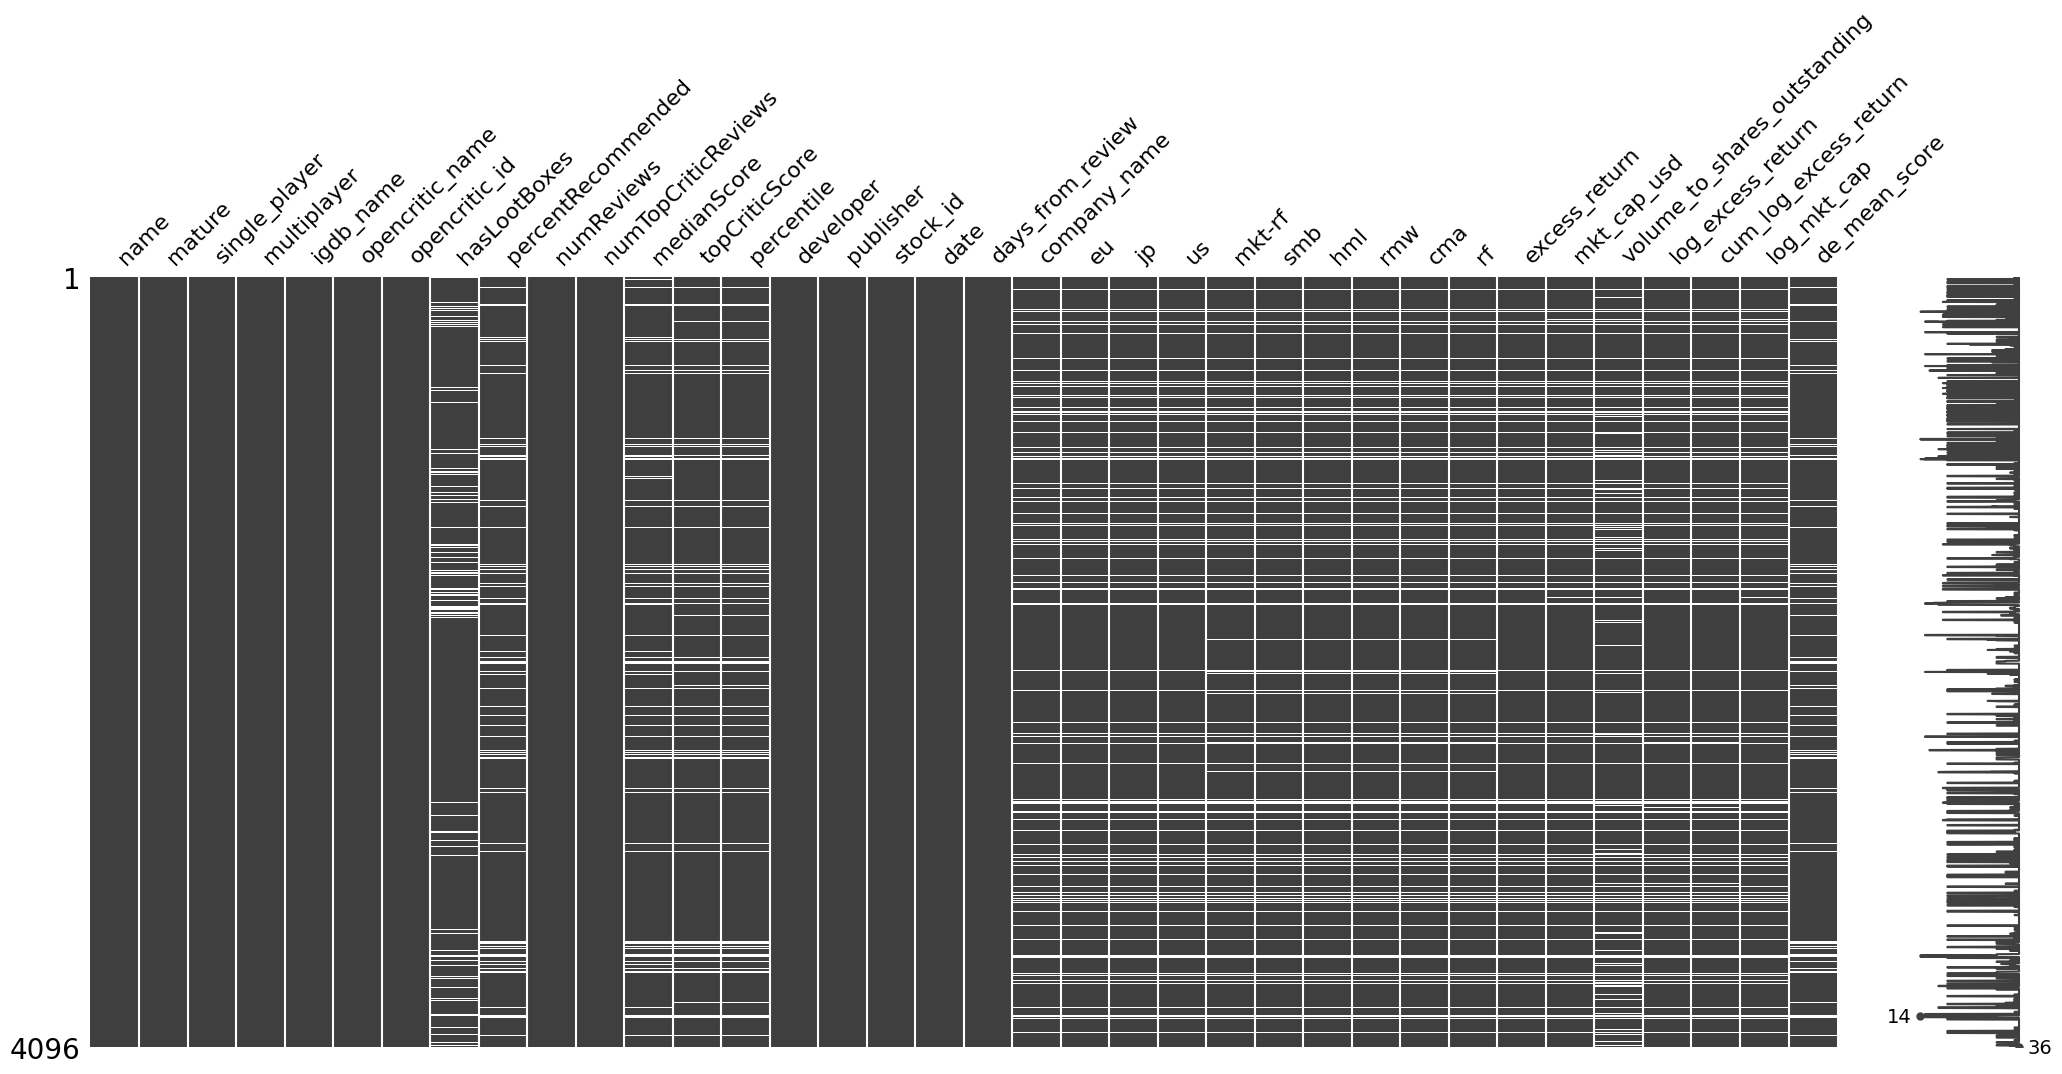

In [3298]:
# Plot missing data.
%matplotlib inline

msno.matrix(df_games_panel)

In [3299]:
# Drop duplicate observations.
duplicate = df_games_panel[df_games_panel.duplicated(['name', 'stock_id', 'date'])]
df_games_panel = df_games_panel.drop(duplicate.index)

In [3300]:
df_games_panel = df_games_panel.dropna()

In [3301]:
df_games_panel.shape

(2304, 36)

<Axes: xlabel='days_from_review', ylabel='Count'>

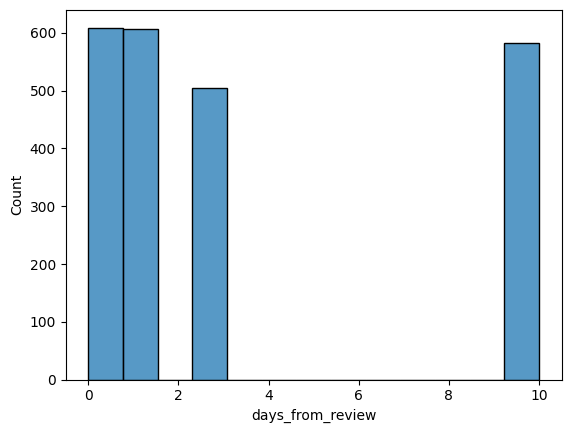

In [3302]:
sns.histplot(df_games_panel['days_from_review'])

# Panel Descriptive Statistics

In [3303]:
df_games_panel['excess_return'] = np.exp(df_games_panel['log_excess_return']) - 1
df_games_panel['cumulative_excess_return'] = np.exp(df_games_panel['cum_log_excess_return']) - 1

Get panel data descriptive statistics.

In [3304]:
df_games_panel.describe()[[
    'log_mkt_cap',
    'mkt-rf',
    'smb',
    'hml',
    'rmw',
    'cma',
    'log_excess_return',
    'volume_to_shares_outstanding'
    ]].style.format({'D':'{:0.5f}'},precision=5)#.to_latex('companies_panel_descriptive_stats.tex')

,log_mkt_cap,mkt-rf,smb,hml,rmw,cma,log_excess_return,volume_to_shares_outstanding
count,2304.00000,2304.00000,2304.00000,2304.00000,2304.00000,2304.00000,2304.00000,2304.00000
mean,21.83999,0.02997,0.00414,0.05826,-0.00320,0.01966,0.00013,0.00609
min,15.08638,-7.82000,-2.16000,-3.61000,-1.84000,-2.29000,-0.71498,0.00000
25%,19.82661,-0.51250,-0.27000,-0.38000,-0.21250,-0.22000,-0.01677,0.00200
50%,22.10124,0.06000,0.00000,0.02000,0.01000,0.00000,0.00042,0.00379
75%,23.67291,0.62000,0.28000,0.47000,0.21000,0.24000,0.01830,0.00674
max,28.57191,9.53000,2.78000,4.57000,1.80000,2.30000,0.29749,0.18317
std,2.61847,1.18006,0.47750,0.78577,0.38810,0.41334,0.04714,0.00990


In [3305]:
def subplot_hist(df, variables, num_columns, x_labels, share_y_axis, image_name, **kwargs):

    titles = kwargs.get('titles', None)
    suptitle = kwargs.get('suptitle', None)
    num_bins = kwargs.get('bins', None)
    figure_size = kwargs.get('figure_size', None)
    y_label_plots = kwargs.get('y_label_plots', None)
    special = kwargs.get('special', None)

    if not figure_size:
        figure_size = (9,9)

    # Calculate the number of subplots based on how many X values being compared.
    num_subplots = len(variables)

    # Calculate how many rows there should be per column.
    rows = math.ceil(num_subplots/num_columns)
    # Number of columns provided as an input.
    cols = num_columns
    fig, axs = plt.subplots(rows, cols, sharey=share_y_axis, figsize = figure_size)
    if rows*cols> num_subplots:
        fig.delaxes(axs.flatten()[-1])
    if suptitle:
        fig.suptitle(suptitle)

    for i, ax in enumerate(axs.flat):

        if special:
            if i == special[0] and special[1]:
                num_bins = special[2]
            else:
                num_bins = num_bins = kwargs.get('bins', None)
        try:
            if i > num_subplots -1 :
                continue
            bin_size = (max(df[variables[i]]) - min(df[variables[i]]))/num_bins
            y = df[variables[i]]
            sns.histplot(
                y,
                kde=True,
                ax=ax,
                binwidth=bin_size,
                edgecolor='black',
                color='gray')
            if titles != None:
                ax.set_title(titles[i])
            if x_labels != None:
                ax.set_xlabel(x_labels[i])
            if y_label_plots:
                if i in y_label_plots:
                    ax.set_ylabel('Count')
                else:
                    ax.set_ylabel('')

        except KeyError:
            print('Too many indices.')
            continue
    fig.savefig(image_name)

In [3306]:
df_games_panel.columns

Index(['name', 'mature', 'single_player', 'multiplayer', 'igdb_name',
       'opencritic_name', 'opencritic_id', 'hasLootBoxes',
       'percentRecommended', 'numReviews', 'numTopCriticReviews',
       'medianScore', 'topCriticScore', 'percentile', 'developer', 'publisher',
       'stock_id', 'date', 'days_from_review', 'company_name', 'eu', 'jp',
       'us', 'mkt-rf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'excess_return',
       'mkt_cap_usd', 'volume_to_shares_outstanding', 'log_excess_return',
       'cum_log_excess_return', 'log_mkt_cap', 'de_mean_score',
       'cumulative_excess_return'],
      dtype='object')

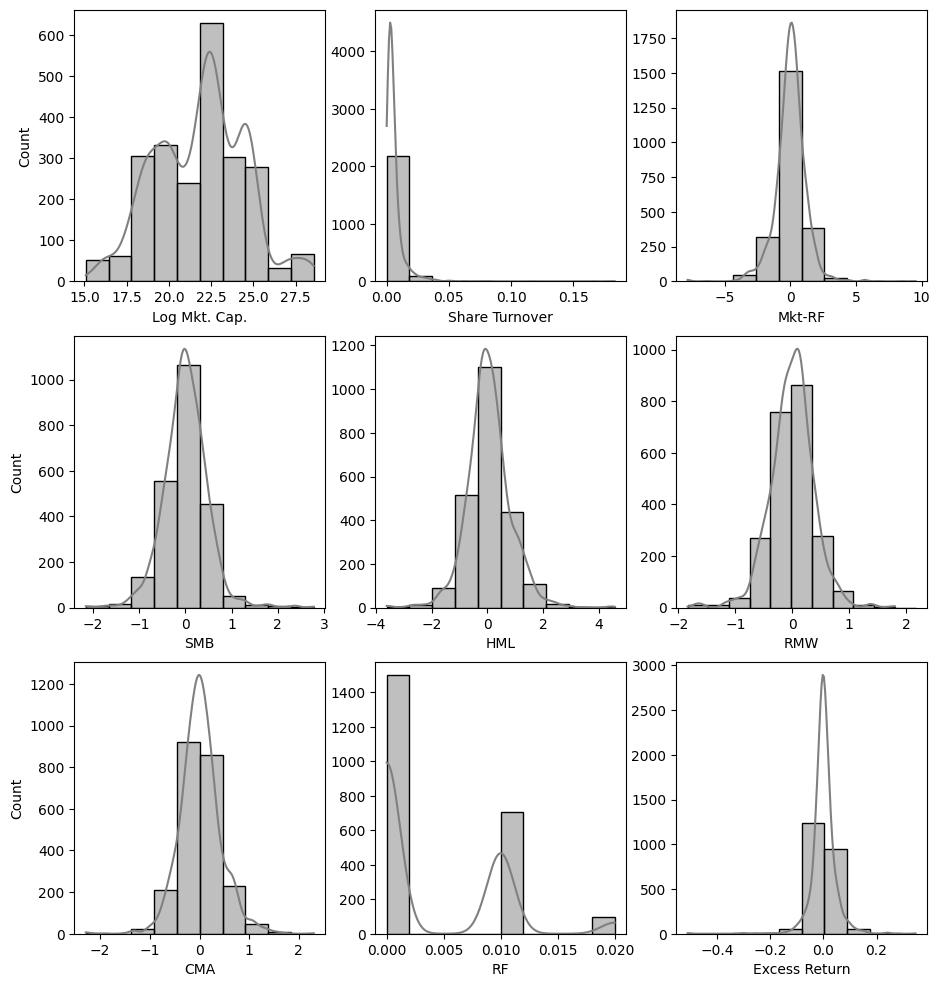

In [3307]:
# Plot histograms of financial data.
subplot_hist(
    df=df_games_panel,
    variables=[
        'log_mkt_cap',
        'volume_to_shares_outstanding',
        'mkt-rf',
        'smb',
        'hml',
        'rmw',
        'cma',
        'rf',
        'excess_return'
        ],
    num_columns=3,
    x_labels=[
        'Log Mkt. Cap.',
        'Share Turnover',
        'Mkt-RF',
        'SMB',
        'HML',
        'RMW',
        'CMA',
        'RF',
        'Excess Return'
        ],
    share_y_axis=False,
    bins=10,
    image_name='panel_financial_metrics_distributions.png',
    figure_size = (11,12),
    y_label_plots=[0,3,6]
    )

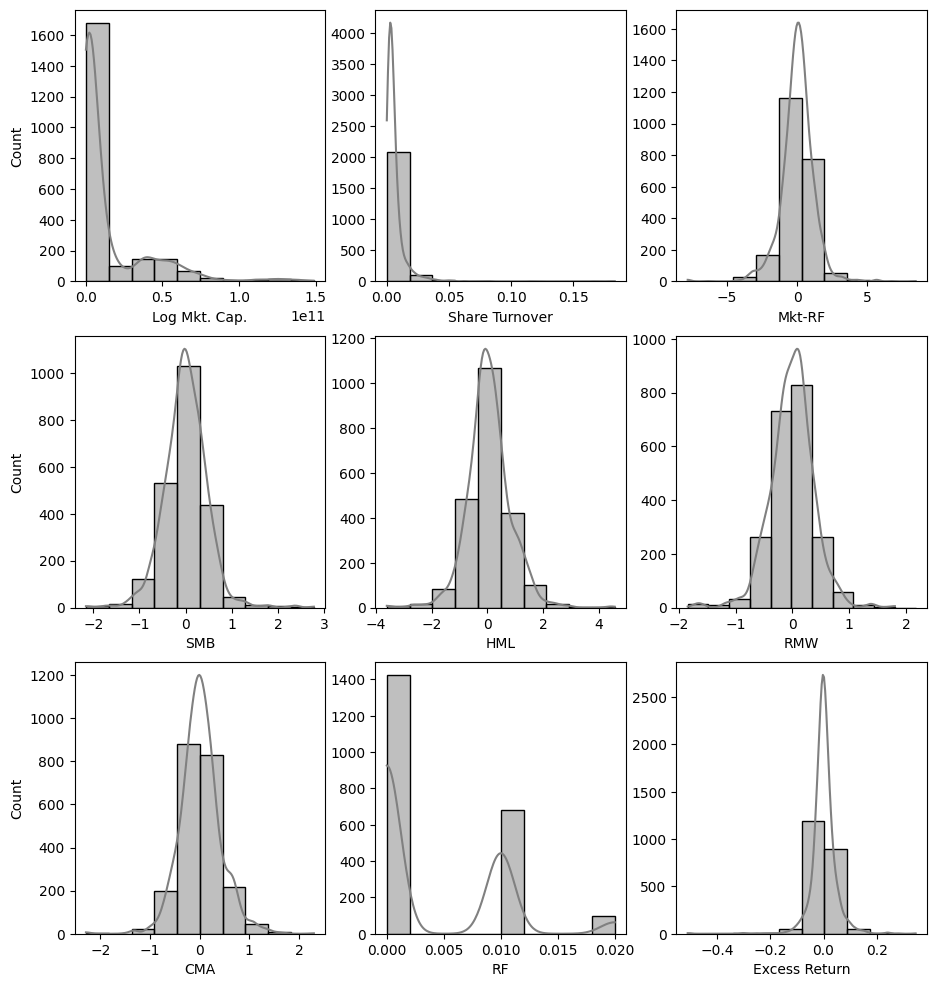

In [3308]:
# Plot histograms (excluding Microsoft) of financial data.
subplot_hist(
    df=df_games_panel[df_games_panel['company_name'] != 'MICROSOFT CORP'],
    variables=[
        'mkt_cap_usd',
        'volume_to_shares_outstanding',
        'mkt-rf',
        'smb',
        'hml',
        'rmw',
        'cma',
        'rf',
        'excess_return'
        ],
    num_columns=3,
    x_labels=[
        'Log Mkt. Cap.',
        'Share Turnover',
        'Mkt-RF',
        'SMB',
        'HML',
        'RMW',
        'CMA',
        'RF',
        'Excess Return'
        ],
    share_y_axis=False,
    bins=10,
    image_name='panel_financial_metrics_distributions_excl_msft.png',
    figure_size = (11,12),
    y_label_plots=[0,3,6]
    )

# Panel Regression

In [3309]:
df_games_panel.columns

Index(['name', 'mature', 'single_player', 'multiplayer', 'igdb_name',
       'opencritic_name', 'opencritic_id', 'hasLootBoxes',
       'percentRecommended', 'numReviews', 'numTopCriticReviews',
       'medianScore', 'topCriticScore', 'percentile', 'developer', 'publisher',
       'stock_id', 'date', 'days_from_review', 'company_name', 'eu', 'jp',
       'us', 'mkt-rf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'excess_return',
       'mkt_cap_usd', 'volume_to_shares_outstanding', 'log_excess_return',
       'cum_log_excess_return', 'log_mkt_cap', 'de_mean_score',
       'cumulative_excess_return'],
      dtype='object')

In [3310]:
# Create interaction term between topCriticScore and size.
df_games_panel['size_score'] = df_games_panel['log_mkt_cap'] * df_games_panel['topCriticScore']
df_games_panel['turnover_score'] = df_games_panel['volume_to_shares_outstanding'] * df_games_panel['topCriticScore']
df_games_panel['days_score'] = df_games_panel['days_from_review'] * df_games_panel['topCriticScore']

In [3311]:
df_games_panel['name'] = df_games_panel['name'].astype('string')
df_games_panel[['name', 'date']].dtypes

name    string[python]
date    datetime64[ns]
dtype: object

In [3312]:
# Set multi-index for panel regression.
df_games_panel = df_games_panel.reset_index()
df_games_panel = df_games_panel.set_index(['name','date'])
df_games_panel.loc['The Last Guardian'].head()


,index,mature,single_player,multiplayer,igdb_name,opencritic_name,opencritic_id,hasLootBoxes,percentRecommended,numReviews,...,mkt_cap_usd,volume_to_shares_outstanding,log_excess_return,cum_log_excess_return,log_mkt_cap,de_mean_score,cumulative_excess_return,size_score,turnover_score,days_score
date,,,,,,,,,,,,,,,,,,,,,
2016-12-05,0,False,True,False,The Last Guardian,The Last Guardian,1524,False,70.49180,128.00000,...,34891481671.08160,0.00533,-0.02263,-0.02263,24.27551,7.77724,-0.02238,1954.87601,0.42950,0.00000
2016-12-06,1024,False,True,False,The Last Guardian,The Last Guardian,1524,False,70.49180,128.00000,...,35359736300.46000,0.00433,0.00769,-0.01494,24.28884,7.77724,-0.01483,1955.94954,0.34850,80.52874
2016-12-08,1025,False,True,False,The Last Guardian,The Last Guardian,1524,False,70.49180,128.00000,...,36056115530.67288,0.00899,0.00942,-0.00552,24.30834,7.77724,-0.00551,1957.52007,0.72379,241.58621
2016-12-15,1026,False,True,False,The Last Guardian,The Last Guardian,1524,False,70.49180,128.00000,...,35931028675.29624,0.00426,0.01427,0.00875,24.30487,7.77724,0.00879,1957.24021,0.34344,805.28736


In [3313]:
df_games_panel.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2304 entries, ('The Last Guardian', Timestamp('2016-12-05 00:00:00')) to ("Bowser's Fury", Timestamp('2021-02-22 00:00:00'))
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   index                         2304 non-null   int64  
 1   mature                        2304 non-null   object 
 2   single_player                 2304 non-null   object 
 3   multiplayer                   2304 non-null   object 
 4   igdb_name                     2304 non-null   object 
 5   opencritic_name               2304 non-null   object 
 6   opencritic_id                 2304 non-null   object 
 7   hasLootBoxes                  2304 non-null   object 
 8   percentRecommended            2304 non-null   float64
 9   numReviews                    2304 non-null   float64
 10  numTopCriticReviews           2304 non-null   float64
 11  medianScore         

In [3314]:
df = df_games_panel
#endog=df['log_excess_return']
endog=df['cum_log_excess_return']
exog=df[[
        'mature',
        'single_player',
        'topCriticScore',
        'size_score',
        #'percentile',
        'publisher',
        'days_from_review',
        'days_score',
        #'eu',
        'jp',
        #'us',
        'mkt-rf',
        'smb',
        'hml',
        'rmw',
        'cma',
        'log_mkt_cap'
]]
exog = sm.add_constant(exog)

print(exog.columns)

# random effects model
model_re = RandomEffects(endog,exog) 
re_res = model_re.fit() 
#print results
print(re_res)

Index(['const', 'mature', 'single_player', 'topCriticScore', 'size_score',
       'publisher', 'days_from_review', 'days_score', 'jp', 'mkt-rf', 'smb',
       'hml', 'rmw', 'cma', 'log_mkt_cap'],
      dtype='object')
                          RandomEffects Estimation Summary                         
Dep. Variable:     cum_log_excess_return   R-squared:                        0.0145
Estimator:                 RandomEffects   R-squared (Between):              0.0068
No. Observations:                   2304   R-squared (Within):               0.0169
Date:                   Mon, Jun 12 2023   R-squared (Overall):              0.0132
Time:                           16:20:09   Log-likelihood                    3798.7
Cov. Estimator:               Unadjusted                                           
                                           F-statistic:                      2.3983
Entities:                            612   P-value                           0.0025
Avg Obs:                  

In [3315]:
# fixed effects model
model_fe = PanelOLS(endog, exog, entity_effects = True, drop_absorbed=True, time_effects=True) 
fe_res = model_fe.fit()
print(fe_res)

/var/folders/8x/1nmny09d6jq3bt7nw4zs3_n80000gp/T/ipykernel_16916/2767426951.py:3: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

mature, single_player, topCriticScore

  fe_res = model_fe.fit()


                            PanelOLS Estimation Summary                            
Dep. Variable:     cum_log_excess_return   R-squared:                        0.0718
Estimator:                      PanelOLS   R-squared (Between):             -7.1223
No. Observations:                   2304   R-squared (Within):              -0.0428
Date:                   Mon, Jun 12 2023   R-squared (Overall):             -4.9268
Time:                           16:20:10   Log-likelihood                    5474.7
Cov. Estimator:               Unadjusted                                           
                                           F-statistic:                      4.0131
Entities:                            612   P-value                           0.0000
Avg Obs:                          3.7647   Distribution:                  F(11,571)
Min Obs:                          1.0000                                           
Max Obs:                          8.0000   F-statistic (robust):            

In [3316]:
np.exp(21.83)

3024464838.845624

In [3324]:
# Run the same regressions but leaving out the outlier excess return.
df = df_games_panel
endog=df['cum_log_excess_return']
exog=df[[
        'mature',
        'single_player',
        'topCriticScore',
        'size_score',
        #'percentile',
        'publisher',
        'days_from_review',
        'days_score',
        #'eu',
        'jp',
        #'us',
        'mkt-rf',
        'smb',
        'hml',
        'rmw',
        'cma',
        'log_mkt_cap'
]]

# Add constant.
exog = sm.add_constant(exog)

# Pooled OLS
pooled_ols_model = PooledOLS(endog, exog).fit()

# Fixed Effects
fixed_effects_model = PanelOLS(endog, exog, entity_effects=True, drop_absorbed=True).fit()

# Random Effects
random_effects_model = RandomEffects(endog, exog).fit()

print(fixed_effects_model.summary.as_latex())

/var/folders/8x/1nmny09d6jq3bt7nw4zs3_n80000gp/T/ipykernel_16916/2926830621.py:31: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

mature, single_player, topCriticScore

  fixed_effects_model = PanelOLS(endog, exog, entity_effects=True, drop_absorbed=True).fit()


\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}     & cum\_log\_excess\_return & \textbf{  R-squared:         }   &      0.0360      \\
\textbf{Estimator:}         &         PanelOLS         & \textbf{  R-squared (Between):}  &     -8.9252      \\
\textbf{No. Observations:}  &           2304           & \textbf{  R-squared (Within):}   &      0.0360      \\
\textbf{Date:}              &     Mon, Jun 12 2023     & \textbf{  R-squared (Overall):}  &     -6.1390      \\
\textbf{Time:}              &         17:45:48         & \textbf{  Log-likelihood     }   &      4172.0      \\
\textbf{Cov. Estimator:}    &        Unadjusted        & \textbf{                     }   &                  \\
\textbf{}                   &                          & \textbf{  F-statistic:       }   &      5.7128      \\
\textbf{Entities:}          &           612            & \textbf{  P-value            }   &      0.0000      \\
\textbf{Avg Obs:}           &          3.7647          & \

In [3325]:
def aic(ll, num_params):
    aic = 2*num_params - 2*ll
    return aic

In [3328]:
# Pooled OLS AIC
aic(2856, 14)

-5684

In [3329]:
# Fixed Effects AIC
aic(4172, 11)

-8322

In [3330]:
# Random Effects AIC
aic(3798.7, 14)

-7569.4